In [3]:
import warnings, os, pathlib
import numpy as np
import torch
import gpytorch
import lightning.pytorch as pl


import hydra
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from tqdm import tqdm
import pandas as pd
import random
import submitit
import time

# from io import read_single_basin
from preprocessing import moving_average

from hydra import initialize, compose
from icecream import ic

from pathlib import Path

from sklearn.metrics import r2_score
import glob
import time
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
runtype = "production"
with initialize(config_path="conf/io", version_base=None):
    conf = compose(config_name=runtype)

# define basin ids
basin_ids = conf['ids']

sample_sizes = [100,200,500,1000,1500,2000,2500]

results_folder = Path('/work/miersch/GP_results/')
work_folder = Path('/work/miersch/submitit')



In [3]:
class mExactGPModel(gpytorch.models.ExactGP, pl.LightningModule):
    def __init__(self, train_x, train_y, likelihood, lr:float = 0.1):
        super(mExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.train_x = train_x
        self.train_y = train_y
        self.lr = lr
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.LinearMean(10)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=10))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def calculate_loss(self,batch):
        x,y = batch
        output = self(x)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        loss = -mll(output,y)
        return loss

    def training_step(self,batch):
        loss = self.calculate_loss(batch)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        #  dataloader with a single batch of the size of the full dataset
        train_dataset = torch.utils.data.TensorDataset(self.train_x, self.train_y)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=len(train_dataset), shuffle=False
        )
        return train_loader
    
def model_rsquared_gp(model,test_x, test_y):
    model.eval()
    with gpytorch.settings.fast_pred_var():
        predictions = model(test_x)

    # Compute y_mean, TSS, and RSS
    y_mean = torch.mean(test_y)
    tss = torch.sum((test_y - y_mean) ** 2)
    rss = torch.sum((predictions.mean - test_y) ** 2)

    # Calculate R-squared
    r_squared = 1 - (rss / tss)
    return r_squared.item()

def model_rsquared_mlr(beta, test_x, test_y):
    test_x = test_x.numpy()
    test_y = test_y.numpy()
    predictions = test_x.dot(beta)
    # Compute y_mean, TSS, and RSS
    y_mean = np.mean(test_y)
    tss = np.sum((test_y - y_mean) ** 2)
    rss = np.sum((predictions - test_y) ** 2)

    # Calculate R-squared
    r_squared = 1 - (rss / tss)
    return r_squared

def train_evaluate_gpr(train_x, 
              train_y,
              test_x,
              test_y,
              training_iter:int,
              output_file:Path,
              id:int,
              sample_size:int
              ):
    
    #define model and training
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = mExactGPModel(train_x, train_y,likelihood)
    callbacks = [
                pl.callbacks.Timer()
            ]
    trainer = pl.Trainer(max_epochs=training_iter,enable_progress_bar=False, callbacks = callbacks, enable_checkpointing=False, logger=False)
    start_time = time.time()
    trainer.fit(model)
    end_time = time.time()
    training_iterations = trainer.global_step
    print(f'Training done with training dataset of size {train_x.size()} for {training_iterations} iterations')

    r2_train_gp = model_rsquared_gp(model, train_x, train_y)
    r2_test_gp = model_rsquared_gp(model, test_x, test_y)

    beta, residuals, rank, s = np.linalg.lstsq(train_x.numpy(), train_y.numpy(), rcond=None)
    r2_train_mlp = model_rsquared_mlr(beta, train_x,train_y)
    r2_test_mlp = model_rsquared_mlr(beta, test_x,test_y)
    result = pd.DataFrame({'r2_train_gp':[r2_train_gp],
                            'r2_test_gp':[r2_test_gp],
                            'r2_train_mlp':[r2_train_mlp],
                            'r2_test_mlp':[r2_test_mlp],
                            'id':id,
                            'sample_size':sample_size,
                            'gp_training_time': end_time - start_time})
    result.to_csv(output_file, index = False)
    return result


In [86]:
for id in basin_ids:
    # read timeseries data
    basin = read_single_basin(directory=os.path.join(conf['data'],'resampled'), id=id)
    # create temperature as 7 day moving average
    basin["tavg7"] = moving_average(basin["tavg"], 7)
    basin = basin[["pre", "tavg7", "snow", "SM", "Q"]]
    with open(
        os.path.join(os.path.join(conf['data'],'resampled'), f"{id}_peak_indices_USWRC.txt"), "r"
        ) as filehandle:
        peak_indices = [
                current_place.rstrip() for current_place in filehandle.readlines()
        ]
            # convert the read list to integers (instead of strings)
        peak_indices = list(map(int, peak_indices))
        # number of peaks (=samples) available for this catchment
    number_of_peaks = len(peak_indices)
    vector_data = pd.DataFrame()
    vector_data['Q'] = basin['Q']
    vector_data['SM'] = basin['SM'].shift(7)
    vector_data['snow'] = basin['snow'].shift(7)
    basin['tavg7'] = moving_average(basin['tavg7'],7)
    vector_data['tavg'] = basin['tavg7'].shift(0)
    for i in range(0,7):
        vector_data[f'prec{i}'] = basin['pre'].shift(i)

    for sample_size in sample_sizes:
        # shuffle peaks for random selection
        random.shuffle(peak_indices)
        train_indices = peak_indices[:sample_size]
        test_indices = peak_indices[sample_size:2*sample_size]
        train_vector_data = vector_data.iloc[train_indices]
        test_vector_data = vector_data.iloc[test_indices]
        scaler = StandardScaler()
        train_vector_data = pd.DataFrame(scaler.fit_transform(train_vector_data), columns = train_vector_data.columns)
        test_vector_data = pd.DataFrame(scaler.fit_transform(test_vector_data), columns = test_vector_data.columns)
        # train_vector_data = (train_vector_data - train_vector_data.mean())/train_vector_data.std()
        # test_vector_data = (test_vector_data - test_vector_data.mean())/test_vector_data.std()


        train_y = torch.tensor(train_vector_data.loc[:,'Q'].values, dtype=torch.float32)
        test_y = torch.tensor(test_vector_data.loc[:,'Q'].values, dtype=torch.float32)
        train_x = torch.tensor(train_vector_data.drop('Q', axis = 1).values, dtype=torch.float32)
        test_x = torch.tensor(test_vector_data.drop('Q', axis = 1).values, dtype=torch.float32)

        execute_directory = work_folder / str(sample_size) / str(id)
        
        os.makedirs(execute_directory, exist_ok=True)

        executor = submitit.AutoExecutor(execute_directory)

        executor.update_parameters(
            timeout_min=5,
            slurm_mem_per_cpu='8G',
            cpus_per_task=1,
            gpus_per_node=1,
        )

        job = executor.submit(train_evaluate_gpr,
                              train_x,
                              train_y,
                              test_x,
                              test_y,
                              300,
                              results_folder / f'{id}_{sample_size}.csv',
                              id,
                              sample_size)
        # train_evaluate_gpr(train_x=train_x,
        #           train_y= train_y,
        #           test_x = test_x,
        #           test_y = test_y,
        #           training_iter=1000,
        #           id  = id,
        #           sample_size = sample_size,
        #           output_file=results_folder / f'{id}_{sample_size}.csv'),
                








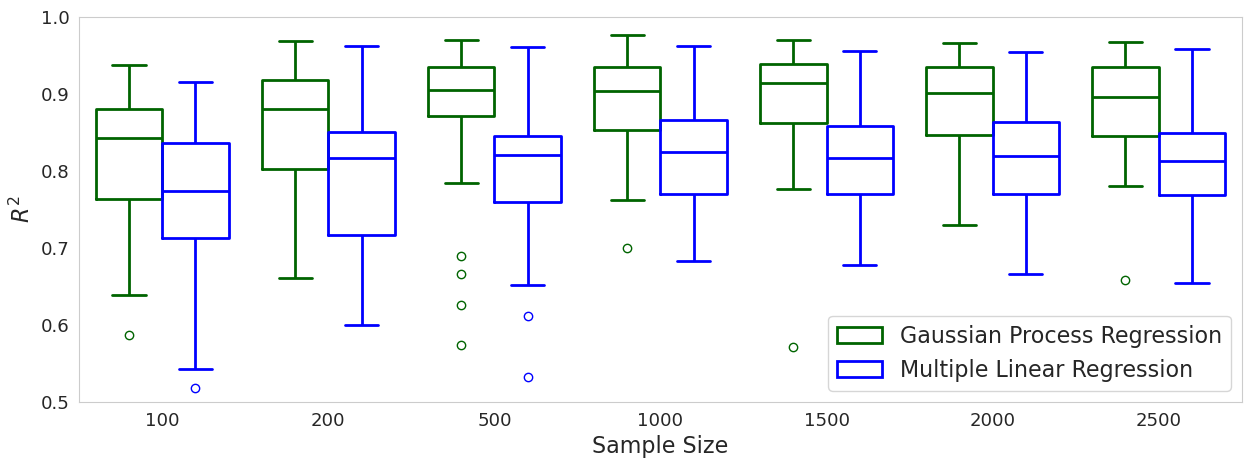

In [4]:
csv_files = glob.glob(os.path.join(results_folder, '*.csv'))
results_dataframes = [pd.read_csv(file) for file in csv_files]
results = pd.concat(results_dataframes, ignore_index=True)

df_long = pd.melt(results, id_vars='sample_size', value_vars=['r2_test_gp', 'r2_test_mlp'],
                  var_name='Model', value_name='R2')


df_long['Model'] = df_long['Model'].replace({
    'r2_test_gp': 'Gaussian Process Regression',
    'r2_test_mlp': 'Multiple Linear Regression'
})

sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, ax = plt.subplots(1,1, figsize=(15, 5))
# Set up the colors for the boxplots


# Create the boxplot
sns.boxplot(x='sample_size', y='R2', hue='Model', data=df_long, palette=['darkgreen','blue'],ax =ax , linewidth=2, fill = False)

# Customize the plot
ax.set_title('')
ax.set_xlabel('Sample Size', fontsize = 16)
ax.set_ylabel(r'$R^2$', fontsize = 16)
ax.legend(title='', loc='lower right', fontsize = 16)
ax.set_ylim(0.5,1)
ax.grid(False)

# Show the plot
plt.savefig(os.path.join('paper_plots', 'gp_mlr_performance.pdf'), format = 'pdf')